##### Imports

In [1]:
from operator import itemgetter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import aim

import plotly.express as px

from skimage.draw import disk

from medpy.metric.binary import dc

from monai.metrics import DiceMetric, HausdorffDistanceMetric, compute_meandice
from monai.transforms import AsDiscrete, EnsureType, Compose
from monai.data import decollate_batch
from monai.losses import DiceLoss
from monai.networks import one_hot

import plotly.express as px

import kornia.augmentation as K

import torch
from torch import nn
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader, TensorDataset

from kedro.extras.datasets.pickle import PickleDataSet

In [2]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.models.segmenter import Net
from tagseg.models.trainer import Trainer
from tagseg.metrics.shape import ShapeDistLoss
from tagseg.pipelines.data_splitting.nodes import split_data

##### Fetch data

In [3]:
dataset = PickleDataSet(filepath='../data/05_model_input/model_input.pt').load()

In [4]:
len(dataset)

4578

In [5]:
examples, labels = dataset.tensors

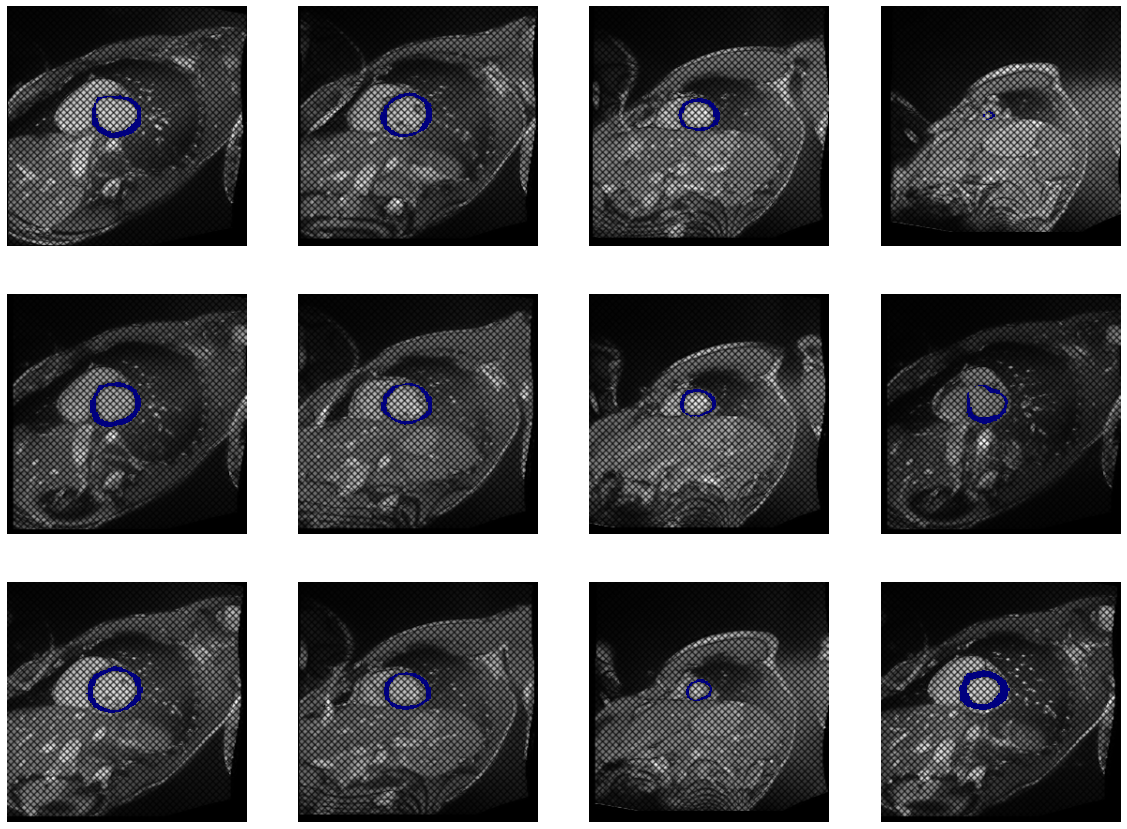

In [7]:
m, n = 3, 4

fig, ax = plt.subplots(m, n, figsize=(20, 15))

for a in range(m * n):
    i, j = a % m, a // m

    ax[i, j].imshow(examples[a, 0], cmap='gray')
    ax[i, j].imshow(np.ma.masked_where(labels[a, 0] == 0, labels[a, 0]), cmap='jet', alpha=1)
    ax[i, j].axis('off')

In [29]:
laplace_kernel = nn.Conv2d(1, 1, (3, 3), bias=False)
laplace_kernel.weight = torch.nn.Parameter(torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]]).double())

In [37]:
storage = []

for image, label in dataset:

    information = dict(
        mean=image.mean().item(),
        std=image.std().item(),
        label_pixels=label.sum().item(),
        variance_lap=laplace_kernel(image.unsqueeze(0)).var().item()
    )

    storage.append(information)

df = pd.DataFrame(storage)

In [38]:
df.head()

mean       std  label_pixels  variance_lap
0 -1.851940  0.251486         641.0      0.008179
1 -1.650840  0.431232        1135.0      0.034171
2 -1.652524  0.426551        1125.0      0.039105
3 -1.678182  0.372601        1014.0      0.031045
4 -1.693206  0.349669         996.0      0.033576

In [10]:
px.histogram(df, x=['mean', 'std'])

In [12]:
px.histogram(df, 'label_pixels')

In [39]:
px.histogram(df, 'variance_lap')